# Загрузка необходимых модулей 

In [15]:
from sklearn.metrics import f1_score
import mglearn
from sklearn import set_config
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import pymorphy2
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay, classification_report, confusion_matrix

In [16]:
set_config(print_changed_only=False)

In [17]:
pd.options.display.max_rows = 450
morph = pymorphy2.MorphAnalyzer()
fileWithStopWOrds = open("../stop_words_russian.txt", "r")
stopWords = fileWithStopWOrds.read().splitlines()

In [18]:
file = open("classesForDatasets.txt", "r")
listsClasses = file.read().splitlines()
listsClasses = [listsClasses[i].split(" ") for i in range(len(listsClasses))]

# Функции для предобработки текста

In [19]:
def processText(text):
    text = re.sub(r'\w{20,}', " ", text)
    text = re.sub(r'(\w+[\.])+[ ](?![A-ZА-Я])', " ", text)
    text = re.sub(r'(?!\n)\W', " ", text)
    text = re.sub(r'\s+[a-яА-Я]\s+', " ", text)
    text = re.sub(r'^[а-яА-Я]+\s', " ", text)
    text = re.sub(r'[a-zA-Z]+', "", text)
    text = re.sub(r'(?<!\. ) [А-Я]\w+', " ", text)
    text = re.sub(r'_', " ", text)
    text = re.sub(r'\d+', " ", text)
    text = re.sub(r' +', " ", text)
    return text

In [20]:
def lemmatize(text):
    words = text.split()
    result = list()
    for word in words:
        p = morph.parse(word)[0]
        result.append(p.normal_form)
    return result

In [21]:
def filterText(texts):
    tempTexts = []
    for i in range(len(texts)):
         tempTexts.append(texts[i].split("\n"))
    resultTexts = []
    for i in range(len(tempTexts)):
        tempEditTexts = []
        for j in range(len(tempTexts[i])):
            if (tempTexts[i][j].count(' ') > 3):
                tempEditTexts.append(tempTexts[i][j])
        resultTexts.append(tempEditTexts)
    return resultTexts

## Загрузка датасета

In [23]:
df = pd.read_csv('../datasets/dataset_75_15.csv', index_col=0)
print('Dataset shape: {}'.format(df.shape))

Dataset shape: (1125, 3)


## Предобработка текстов

In [24]:
allTexts, allTargets = [text for text in tqdm(df['Document'])], [target for target in tqdm(df['indexCategory'])]

100%|██████████████████████████████████| 1125/1125 [00:00<00:00, 1649280.67it/s]


In [25]:
def getTextsForVectorization(allTexts):
    """Подготавливает текст для векторизации: регулярные выражения, токенизация, лемматизация"""
    filteredTexts = filterText(allTexts)
    afterPreprocessingTexts = [] 
    normalFormTexts = []
    for i in tqdm(range(len(filteredTexts))):
        filteredTexts[i] =  "\n".join(filteredTexts[i])
        filteredTexts[i] = processText(filteredTexts[i])
        normalFormTexts.append(" ".join(list(set(lemmatize(filteredTexts[i])))))
    return normalFormTexts

In [26]:
textsForVectorization = getTextsForVectorization(allTexts)

100%|███████████████████████████████████████| 1125/1125 [04:09<00:00,  4.52it/s]


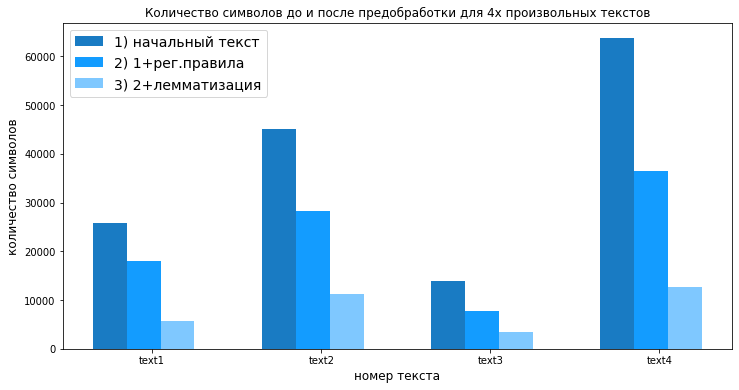

In [28]:
fig, ax = plt.subplots()

plt.bar([1,2,3,4], [25818, 45121, 13889, 63719], width = 0.2, alpha=0.9, color='#006dbd', label = 'asss')
plt.bar([1.2,2.2,3.2,4.2], [17952, 28248, 7795, 36372],width = 0.2, color='#139CFF', label ='dsss')
plt.bar([1.4,2.4,3.4,4.4], [5620, 11241, 3391, 12775], width = 0.2, alpha=0.5, color='#0093ff',label = 'sddd')

ax.set_xticks([1.25, 2.25, 3.25, 4.25])
ax.set_xticklabels(['text1', 'text2', 'text3', 'text4'])

plt.legend(['1) начальный текст', '2) 1+рег.правила', '3) 2+лемматизация'], loc='upper left', fontsize=14)
plt.xlabel("номер текста", fontsize=12)
plt.ylabel("количество символов",fontsize=12)
fig.set_figwidth(12)
fig.set_figheight(6)   
plt.savefig('texts.png', dpi=300, bbox_inches = "tight")
plt.title("Количество символов до и после предобработки для 4х произвольных текстов")
plt.show()

In [29]:
vect = CountVectorizer(stop_words = stopWords, min_df = 3, max_df = 0.6).fit(textsForVectorization)
vectorizedTexts = vect.transform(textsForVectorization)
vectorizedTexts = TfidfTransformer().fit_transform(vectorizedTexts)
print("vectorizedTexts:\n{}".format(repr(vectorizedTexts)))

vectorizedTexts:
<1125x15925 sparse matrix of type '<class 'numpy.float64'>'
	with 459939 stored elements in Compressed Sparse Row format>


In [30]:
#max_value2 = vectorizedTexts.max(axis=0).toarray().ravel()
#sorted2 = max_value2.argsort()
#feature_names2 = np.array(vect.get_feature_names_out())
tfidfDF = pd.DataFrame(vectorizedTexts.toarray(), index=allTargets, columns=vect.get_feature_names_out())

In [31]:
tfidfDF = tfidfDF.stack().reset_index()
tfidfDF = tfidfDF.rename(columns={0:'tfidf', 'level_0': 'class','level_1': 'feature'})

In [32]:
topTfidf = tfidfDF.sort_values(by=['class','tfidf'], ascending=[True,False]).groupby(['class']).head(30)
topTfidfDedublication = topTfidf.drop_duplicates(subset=['feature', 'class']).groupby(['class']).head(8)

In [33]:
nameClass = []
for i in range(len(listsClasses[0])):
    res = [listsClasses[0][i]]*(8)
    nameClass+=res
topTfidfDedublication['nameClass'] = nameClass

In [34]:
import altair as alt
top_tfidf_plusRand = topTfidfDedublication.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(topTfidfDedublication.shape[0])*0.0001

base = alt.Chart(top_tfidf_plusRand).encode(alt.X('rank:O', axis=alt.Axis(labelAngle=0), title=''), alt.Y('nameClass:N', title='')).transform_window(
    rank = 'rank()',
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["nameClass"],
)

heatmap = base.mark_rect().encode(
    color = alt.Color ('tfidf:Q', scale=alt.Scale(scheme='blues'),
                    )
)

text = base.mark_text(baseline='middle').encode(
    text = 'feature:N',
    color = alt.condition(alt.datum.tfidf >= 0.4, alt.value('white'), alt.value('black'))
)

(heatmap + text).properties(width = 850, height = 300)

alt.LayerChart(...)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(vectorizedTexts, allTargets, random_state=0, test_size=0.33, stratify=allTargets)

In [36]:
y = dict(collections.Counter(y_train))
index = y.keys()
values = y.values()

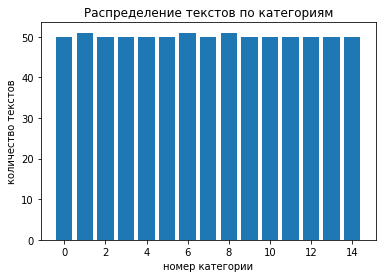

In [37]:
plt.title('Распределение текстов по категориям')
plt.bar(index,values)
plt.xlabel("номер категории")
plt.ylabel("количество текстов")
plt.show()

## Настройка гиперпараметров 

In [38]:
gsLogreg = LogisticRegression(max_iter = 800)

In [39]:
gsMNB = MultinomialNB()

In [40]:
gsDecisionTree = DecisionTreeClassifier(random_state=0)

In [41]:
C = np.logspace(0, 5, 40)
searcherForLogReg = GridSearchCV(gsLogreg, {"C": C}, scoring = 'f1_micro', cv = 5)
searcherForLogReg.fit(X_train, y_train)
bestC = searcherForLogReg.best_params_["C"]
print("Наилучшее значение параметра C: {:.2f}".format(bestC))
print("Наилучшее значение крос-валидац. проверки: {:.2f}".format(searcherForLogReg.best_score_))

Наилучшее значение параметра C: 9426.68
Наилучшее значение крос-валидац. проверки: 0.59


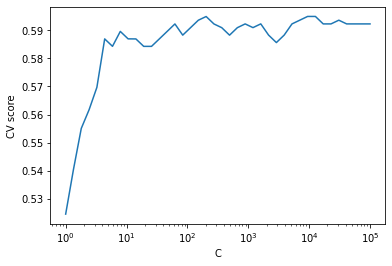

In [48]:
_ = plt.plot(C, searcherForLogReg.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")
#plt.title("Зависимость f1_micro от параметра C")
plt.savefig('parC.jpeg', dpi=300, bbox_inches = "tight")
plt.show()

In [49]:
alpha = np.logspace(0, -9, 100)
searcherForNB = GridSearchCV(gsMNB, {"alpha": alpha}, scoring = 'f1_micro', cv = 5)
searcherForNB.fit(X_train, y_train)
bestAlpha = searcherForNB.best_params_["alpha"]
print("Наилучшее значение параметра alpha: {:.2f}".format(bestAlpha))
print("Наилучшее значение крос-валидац. проверки: {:.2f}".format(searcherForNB.best_score_))

Наилучшее значение параметра alpha: 0.01
Наилучшее значение крос-валидац. проверки: 0.53


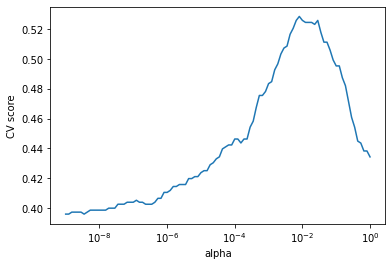

In [50]:
_ = plt.plot(alpha, searcherForNB.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
#plt.title("Зависимость f1_micro от параметра alpha")
plt.savefig('parAlpha.jpeg', dpi=300, bbox_inches = "tight")
plt.show()

In [47]:
maxDepth = np.linspace(4, 70, 67)
searcherForDTree = GridSearchCV(gsDecisionTree, {'max_depth': maxDepth}, scoring = 'f1_micro', cv = 5)
searcherForDTree.fit(X_train, y_train)
bestMaxDepth = searcherForDTree.best_params_["max_depth"]
print("Наилучшее значение параметра max_depth: {:.2f}".format(bestMaxDepth))
print("Наилучшее значение крос-валидац. проверки: {:.2f}".format(searcherForDTree.best_score_))

Наилучшее значение параметра max_depth: 45.00
Наилучшее значение крос-валидац. проверки: 0.27


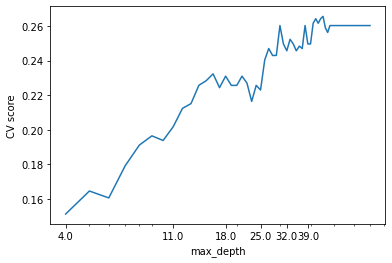

In [51]:
_ = plt.plot(maxDepth, searcherForDTree.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xticks(maxDepth[0:37:7], maxDepth[0:37:7])
plt.xlabel("max_depth")
plt.ylabel("CV score")
#plt.title("Зависимость f1_micro от параметра max_depth")
plt.savefig('parMaxDepth.jpeg', dpi=300, bbox_inches = "tight")
plt.show()

## Построение моделей машинного обучения

In [52]:
multinomialNB = MultinomialNB(alpha=bestAlpha)
multinomialNB.fit(X_train, y_train)

MultinomialNB(alpha=0.008111308307896872, class_prior=None, fit_prior=True)

In [53]:
logreg = LogisticRegression(C = bestC, max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(C=9426.684551178845, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
decisionTree = DecisionTreeClassifier(random_state = 0, max_depth = 42, min_samples_split = 40)
decisionTree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=42, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=40, min_weight_fraction_leaf=0.0,
                       random_state=0, splitter='best')

## Результат

In [55]:
print("DT f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test, decisionTree.predict(X_test), average='micro')))
print("MNB f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test, multinomialNB.predict(X_test), average='micro')))
print("LR f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test, logreg.predict(X_test), average='micro')))

DT f1_score на тестовом наборе: 0.32
MNB f1_score на тестовом наборе: 0.62
LR f1_score на тестовом наборе: 0.67


In [56]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56        25
           1       0.52      0.58      0.55        24
           2       0.83      0.60      0.70        25
           3       0.60      0.84      0.70        25
           4       0.55      0.64      0.59        25
           5       0.63      0.48      0.55        25
           6       0.69      0.46      0.55        24
           7       0.83      0.76      0.79        25
           8       0.44      0.50      0.47        24
           9       0.74      0.80      0.77        25
          10       0.50      0.36      0.42        25
          11       0.80      0.96      0.87        25
          12       0.90      0.76      0.83        25
          13       0.81      0.88      0.85        25
          14       0.73      0.88      0.80        25

    accuracy                           0.67       372
   macro avg       0.68      0.67      0.67       372
weighted avg       0.68   

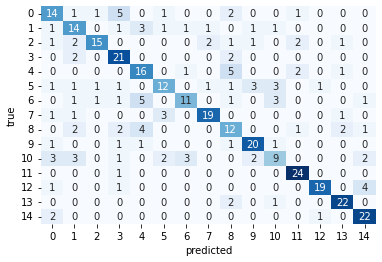

In [57]:
cm = confusion_matrix(y_test, logreg.predict(X_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="predicted", ylabel="true")
plt.yticks(rotation=0)
plt.savefig('confmatrix.png', dpi=300, bbox_inches = "tight")
plt.show()

## Micro-average precision-recall curve

In [69]:
logregPredictProba = logreg.predict_proba(X_test)
multinomialNBPredictProba = multinomialNB.predict_proba(X_test)
DTPredictProba = decisionTree.predict_proba(X_test)

In [70]:
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=[i for i in range(0, 15)])

In [71]:
precision = dict()
recall = dict()
averagePrecision = dict()

In [72]:
precision["microLR"], recall["microLR"], _ = precision_recall_curve(y_test_binarized.ravel(), logregPredictProba.ravel())
averagePrecision["microLR"] = average_precision_score(y_test_binarized, logregPredictProba, average="micro")
precision["microNB"], recall["microNB"], _ = precision_recall_curve(y_test_binarized.ravel(), multinomialNBPredictProba.ravel())
averagePrecision["microNB"] = average_precision_score(y_test_binarized, multinomialNBPredictProba, average="micro")
precision["microDT"], recall["microDT"], _ = precision_recall_curve(y_test_binarized.ravel(), DTPredictProba.ravel())
averagePrecision["microDT"] = average_precision_score(y_test_binarized, DTPredictProba, average="micro")

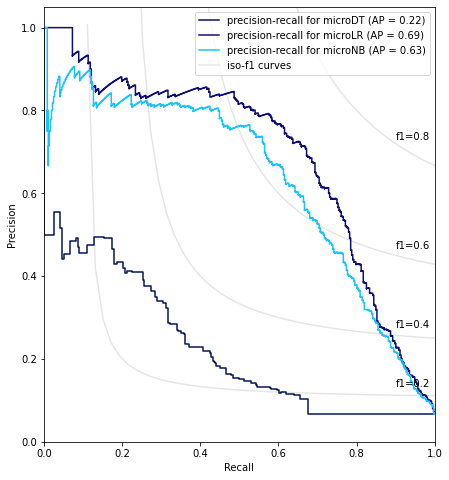

In [73]:
import matplotlib.pyplot as plt
from itertools import cycle

_, ax = plt.subplots(figsize=(7, 8))
colors = ["#001452", "#0d0d73", "#19c3ff"]
names = ['microDT', 'microLR', 'microNB']
f1Scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f1Scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

for name, color in zip(names, colors):
    display = PrecisionRecallDisplay(
        recall=recall[name],
        precision=precision[name],
        average_precision=averagePrecision[name],
    )
    display.plot(ax=ax, name=f"precision-recall for {name}", color=color)    


# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="upper right")
plt.savefig('PRcurve.jpeg', dpi=300, bbox_inches = "tight")
plt.show()

# Дополнительные сведения

In [74]:
def printTop10(vectorizer, clf):
    """Prints features with the highest coefficient values, per class"""
    featureNames = vectorizer.get_feature_names_out()
    for i, classLabel in enumerate(listsClasses[2]):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (classLabel, " ".join(featureNames[j] for j in top10)))

In [75]:
printTop10(vect, logreg)

KnD: свежий подсистема устанавливаться переустановка накопитель целостность редакция бета основать драйвер
DEV: среда компилировать указатель кроссплатформенный статический синтаксис программирование редактор компилятор отладчик
WEB: браузерный движок отключить страница сайт связанный адресный браузер хром вкладка
USER: понравиться флешка копировать окно офисный меню мышь находить оболочка стол
DEVOPS: автоматизация убедиться пода развернуть автоматизировать создать подовый кластер инфраструктура контейнер
ORG: айтишник образовательный сообщить спустя клиент вмвладислав совместный партнёр млн директор
SPECIAL: указываться эмулировать эмулятор формирование хост проброс играть виртуализация эмуляция гостевой
SECURITY: атаковать устранить затрагивать выявить выпустить безопасность обнаружить атака исследователь злоумышленник
SYSADM: аналогично разделяться пространство вывести соединение флаг указывать опция сокет сетевой
MULTIMEDIA: медиацентр изображение звук формат эффект графический ри

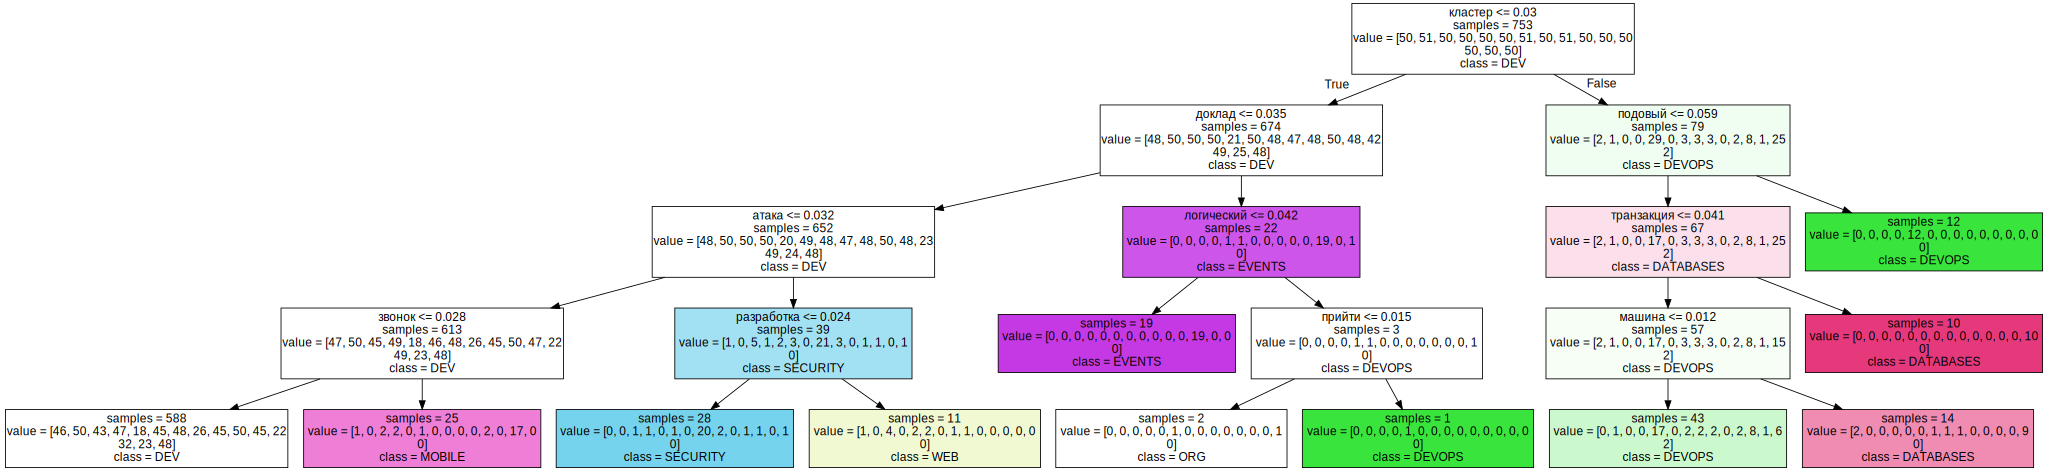

In [76]:
from sklearn.tree import export_graphviz
import graphviz
tree = DecisionTreeClassifier(random_state = 0, max_depth = 4)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file = 'tree.dot', feature_names = vect.get_feature_names_out(), class_names=listsClasses[0], impurity = False, filled=True)
#fig = plt.figure(figsize=(30, 20))
#plot_tree(clf, feature_names=feature_names, fontsize= 6, class_names = classes)
#plt.show()
with open('tree.dot') as f:
    dotGraph = f.read()
graphviz.Source(dotGraph)

# Рассмотрение методов машинного обучения с другими датасетами 

In [77]:
datasets = [
'../datasets/dataset_150_10.csv', 
'../datasets/dataset_200_15.csv',
'../datasets/dataset_350_4.csv',
'../datasets/dataset_200_23.csv',
'../datasets/dataset_max_23.csv'
]

In [78]:
def predict(dataset):
    df = pd.read_csv(dataset, index_col=0)
    
    print('Dataset {} shape: {}'.format(dataset, df.shape))
        
    allTexts, allTargets = [text for text in tqdm(df['Document'])], [target for target in tqdm(df['indexCategory'])]
    textsForVectorization = getTextsForVectorization(allTexts)
    
    tfidf = TfidfVectorizer(stop_words = stopWords, min_df = 3, max_df = 0.6)
    vectorizedTexts = tfidf.fit_transform(textsForVectorization)
    X_train, X_test, y_train, y_test = train_test_split(vectorizedTexts, allTargets, random_state=0, test_size=0.33, stratify=allTargets)

    logReg = LogisticRegression(C = bestC, max_iter=900)
    logReg.fit(X_train, y_train)
    
    decisionTreeCl = DecisionTreeClassifier(random_state = 0, max_depth = 42, min_samples_split = 40)
    decisionTreeCl.fit(X_train, y_train)
    
    multinomialNBCl = MultinomialNB(alpha=bestAlpha)
    multinomialNBCl.fit(X_train, y_train)
    
        
    y_pred_DT = decisionTreeCl.predict(X_test)
    y_pred_LR = logReg.predict(X_test)
    y_pred_MNB = multinomialNBCl.predict(X_test)
    
    print("\nDT f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test, y_pred_DT, average='micro')))
    print("MNB f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test, y_pred_MNB, average='micro')))
    print("LR f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test, y_pred_LR, average='micro')))
    return [[y_pred_DT, y_pred_LR, y_pred_MNB], [y_test]]

In [79]:
yForScore1 = predict(datasets[2])

Dataset ../datasets/dataset_350_4.csv shape: (1400, 3)


100%|███████████████████████████████████████| 1400/1400 [05:41<00:00,  4.10it/s]



DT f1_score на тестовом наборе: 0.61
MNB f1_score на тестовом наборе: 0.77
LR f1_score на тестовом наборе: 0.82


In [80]:
yForScore2 = predict(datasets[0])

Dataset ../datasets/dataset_150_10.csv shape: (1500, 3)


100%|███████████████████████████████████████| 1500/1500 [05:25<00:00,  4.61it/s]



DT f1_score на тестовом наборе: 0.34
MNB f1_score на тестовом наборе: 0.56
LR f1_score на тестовом наборе: 0.63


In [81]:
yForScore3 = predict(datasets[1])

Dataset ../datasets/dataset_200_15.csv shape: (2485, 3)


100%|███████████████████████████████████████| 2485/2485 [08:52<00:00,  4.67it/s]



DT f1_score на тестовом наборе: 0.31
MNB f1_score на тестовом наборе: 0.52
LR f1_score на тестовом наборе: 0.62


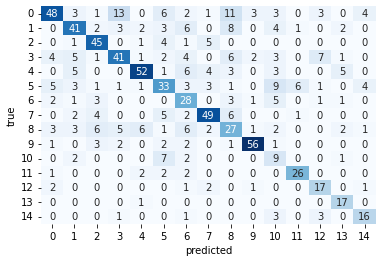

In [119]:
cm = confusion_matrix(yForScore3[0][1], yForScore3[1][0])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="predicted", ylabel="true")
plt.yticks(rotation=0)
plt.show()

In [120]:
print(classification_report(yForScore3[0][1], yForScore3[1][0]))

              precision    recall  f1-score   support

           0       0.73      0.49      0.59        98
           1       0.62      0.57      0.59        72
           2       0.68      0.79      0.73        57
           3       0.62      0.53      0.57        77
           4       0.79      0.66      0.72        79
           5       0.50      0.46      0.48        71
           6       0.42      0.62      0.50        45
           7       0.74      0.71      0.73        69
           8       0.41      0.42      0.41        65
           9       0.88      0.82      0.85        68
          10       0.21      0.43      0.29        21
          11       0.76      0.79      0.78        33
          12       0.53      0.71      0.61        24
          13       0.59      0.94      0.72        18
          14       0.62      0.67      0.64        24

    accuracy                           0.62       821
   macro avg       0.61      0.64      0.61       821
weighted avg       0.64   

In [83]:
yForScore4 = predict(datasets[3])

Dataset ../datasets/dataset_200_23.csv shape: (2880, 3)


100%|███████████████████████████████████████| 2880/2880 [11:10<00:00,  4.29it/s]



DT f1_score на тестовом наборе: 0.27
MNB f1_score на тестовом наборе: 0.50
LR f1_score на тестовом наборе: 0.58


# Бинарная классификация 

In [121]:
dfBin = pd.read_csv(datasets[4], index_col=0)
print('Dataset {} shape: {}'.format(datasets[4], dfBin.shape))

Dataset ../datasets/dataset_max_23.csv shape: (4872, 3)


In [92]:
allTextsBin, allTargetsBin = [text for text in tqdm(dfBin['Document'])], [target for target in tqdm(dfBin['indexCategory'])]
textsForVectorizationBin = getTextsForVectorization(allTextsBin)

100%|███████████████████████████████████████| 4872/4872 [19:38<00:00,  4.13it/s]


In [111]:
tfidfBin = TfidfVectorizer(stop_words = stopWords, min_df = 3, max_df = 0.6)
vectorizedTextsBin = tfidfBin.fit_transform(textsForVectorizationBin)
    
X_trainBin, X_testBin, y_trainBin, y_testBin = train_test_split(vectorizedTextsBin, allTargetsBin, random_state=0, test_size=0.33, stratify=allTargetsBin)

In [124]:
class1 = [i for i in range(13, 23)]
y_train_binarize = []
y_test_binarize = []
for i in y_trainBin:
    if i in class1:
        y_train_binarize.append(1)
    else:
        y_train_binarize.append(0)

for i in y_testBin:
    if i in class1:
        y_test_binarize.append(1)
    else:
        y_test_binarize.append(0)

In [122]:
logRegBin = LogisticRegression(C = bestC, max_iter = 900)
logRegBin.fit(X_trainBin, y_train_binarize)
    
decisionTreeClBin = DecisionTreeClassifier(random_state = 0, max_depth = 42, min_samples_split = 40)
decisionTreeClBin.fit(X_trainBin, y_train_binarize)
    
multinomialNBClBin = MultinomialNB(alpha=bestAlpha)
multinomialNBClBin.fit(X_trainBin, y_train_binarize)
    
y_pred_DTBin = decisionTreeClBin.predict(X_testBin)
y_pred_LRBin = logRegBin.predict(X_testBin)
y_pred_MNBBin = multinomialNBClBin.predict(X_testBin)
    
print("\nDT f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test_binarize, y_pred_DTBin, average='micro')))
print("MNB f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test_binarize, y_pred_MNBBin, average='micro')))
print("LR f1_score на тестовом наборе: {:.2f}".format(f1_score(y_test_binarize, y_pred_LRBin, average='micro')))


DT f1_score на тестовом наборе: 0.87
MNB f1_score на тестовом наборе: 0.90
LR f1_score на тестовом наборе: 0.91


In [123]:
cm = confusion_matrix(y_test_binarize, y_pred_LRBin)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="predicted", ylabel="true")
plt.yticks(rotation=0)
plt.savefig('confmatrix.png', dpi=300, bbox_inches = "tight")
plt.show()

In [125]:
print(classification_report(y_test_binarize, y_pred_LRBin))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1423
           1       0.84      0.31      0.45       185

    accuracy                           0.91      1608
   macro avg       0.88      0.65      0.70      1608
weighted avg       0.91      0.91      0.90      1608



In [126]:
dfLR = logRegBin.decision_function(X_testBin) > -.9

In [127]:
print(classification_report(y_test_binarize, dfLR))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1423
           1       0.77      0.40      0.53       185

    accuracy                           0.92      1608
   macro avg       0.85      0.69      0.74      1608
weighted avg       0.91      0.92      0.91      1608



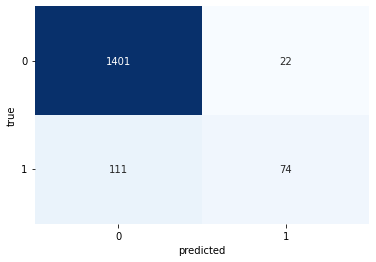

In [128]:
cm = confusion_matrix(y_test_binarize, dfLR)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="predicted", ylabel="true")
plt.yticks(rotation=0)
plt.savefig('confmatrix.png', dpi=300, bbox_inches = "tight")
plt.show()

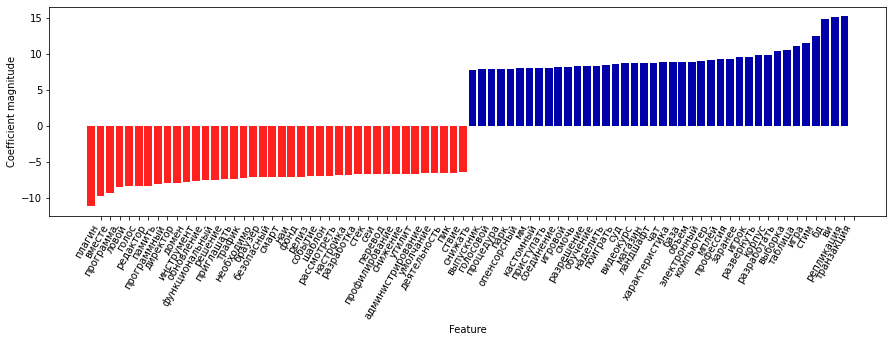

In [129]:
featureNames = tfidfBin.get_feature_names_out()
mglearn.tools.visualize_coefficients(logRegBin.coef_, featureNames, n_top_features=40)